# **Bank Customer Churn**

The dataset for this notebook can be found on [Kaggle](https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers).

### But... what does **churn** mean?

The *churn rate* refers to the proportion of customers or subscribers that left the customer base of a supplier in a given period of time. It may indicate that the clients are not satisfied with the service or that there are better offers from the competitors of the business. It is usually an important metric for subscriber-based service models.
<br/>
<br/>
For this case, specifically, it is a measure of the number of people that left the customer base of the bank. Source: [Wikipedia](https://github.com/iCoelho24/Telco-Churn/blob/main/C%C3%B3digo/Telco.ipynb)


### *So... what do we want to do?*

Based on the exploration of the information that we have available, we will:
1. identify the factors thar contribute to customer churn;
2. try to create a model that predicts the clients that are more likely to leave the bank in the future, so that the bank gets a chance to act before losing its customers.

### And what **data** do we have available?

These are **14** columns  available, the last one being the target:
- RowNumber—corresponds to the record (row) number;
- CustomerId—contains random values;
- Surname—the surname of a customer;
- CreditScore—the credit score for that client;
- Geography—a customer’s location;
- Gender—if client is male or female;
- Age— how old the client is;
- Tenure—refers to the number of years that the customer has been a client of the bank;
- Balance—the amount of money a client has in their account;
- NumOfProducts—refers to the number of products that a customer has with the bank;
- HasCrCard—denotes whether or not a customer has a credit card;
- IsActiveMember— if member is an active user of the bank account;
- EstimatedSalary—the salary the bank estimates the client receives;
- Exited—whether or not the customer left the bank.

In [1]:

# imports

# data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# preparation for creatig the models
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# improving model parameters
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

#models used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#metrics
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, plot_roc_curve, roc_curve

import warnings
warnings.filterwarnings('ignore')

First we will import the data:

In [2]:
df_bank_churn = pd.read_csv('churn.csv')
display(df_bank_churn.head())
print(f'Our table has {df_bank_churn.shape[1]} columns and {df_bank_churn.shape[0]} records.')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Our table has 14 columns and 10000 records.


In [3]:
df_bank_churn.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [4]:
df_bank_churn.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [5]:
df_bank_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Highlights**
- we have no missing values;
- there are 3 datatypes: float, integer and object;

**Actions**
- Based on the description of the variables and the analysis above, we decide to **discard the 3 first columns**. They are all related to a specific customer and will not contribute to our analysis or our model.

In [6]:
df_bank_churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Let's analyze the remaining data:

In [7]:
df_bank_churn.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Highlights**
- the minimum credit score for the clients in the dataset is 350, and the maximum 850;
- the customers age range from 18 to 92 years old;
- the oldest customers have been with the bank for 10 years;
- All clients have at least 1 product, and the max number of products is 4;
- Most clients have a credit card;
- Around 20% of clients left the bank in the given period.

# **Exploratory Data Analysis**

In [8]:
df_bank_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Categorical/Discrete Variables

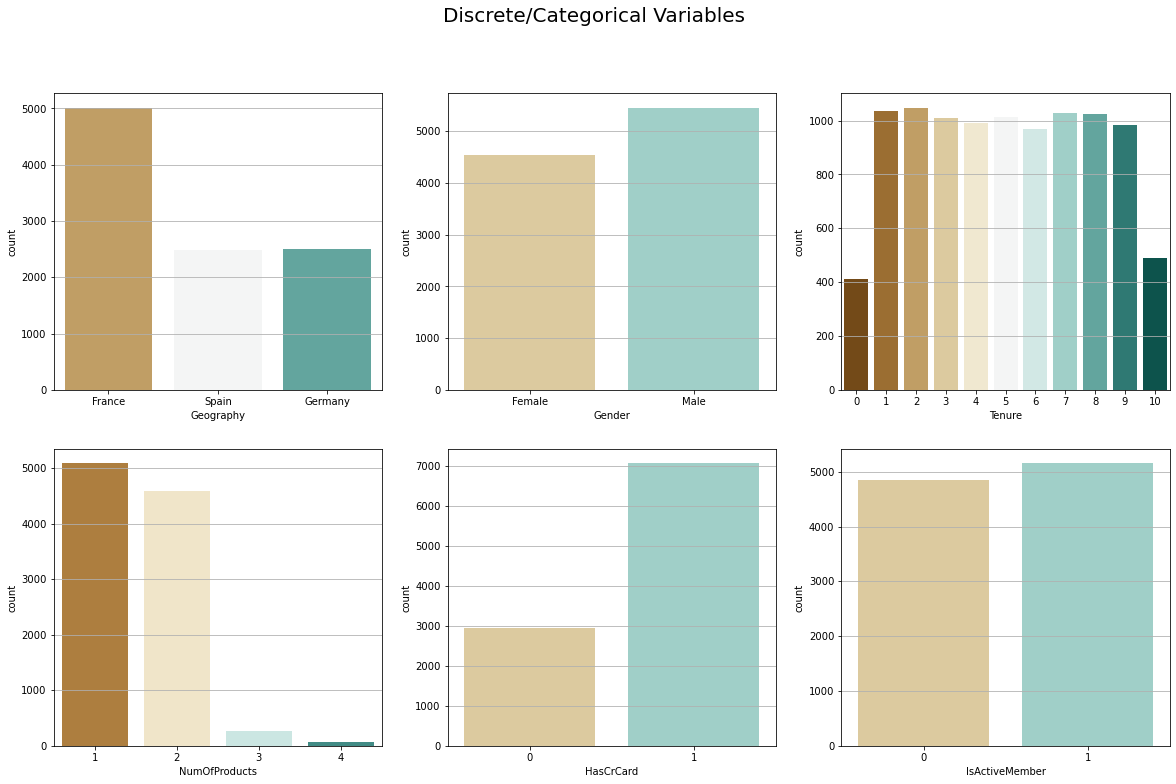

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(20,12))
 
sns.countplot(data=df_bank_churn, x='Geography', palette = 'BrBG', ax=ax[0,0])
ax[0,0].grid(axis='y')

sns.countplot(data=df_bank_churn, x='Gender', palette = 'BrBG', ax=ax[0,1])
ax[0,1].grid(axis='y')

sns.countplot(data=df_bank_churn, x='Tenure', palette = 'BrBG', ax=ax[0,2])
ax[0,2].grid(axis='y')

sns.countplot(data=df_bank_churn, x='NumOfProducts', palette = 'BrBG', ax=ax[1,0])
ax[1,0].grid(axis='y')

sns.countplot(data=df_bank_churn, x='HasCrCard', palette = 'BrBG', ax=ax[1,1])
ax[1,1].grid(axis='y')

sns.countplot(data=df_bank_churn, x='IsActiveMember', palette = 'BrBG', ax=ax[1,2])
ax[1,2].grid(axis='y')


plt.suptitle('Discrete/Categorical Variables', fontsize=20)
plt.show()


**Highlights**
- Most people are from France, and we have almost the same number from people from Germany and Spain;
- Most clients are Male;
- Most clients seem to have a good relationship with the bank, and have between 1 and 9 years as customers;
- Most clients are using 1 or 2 products;
- around 70% of the clients own a credit card;
- we have a somewhat balanced quantity of active and inactive members.

**Questions**
- what does being an 'active member' mean? 
-- Sadly, this can only be answered by a business analyst.

### Continuous variables

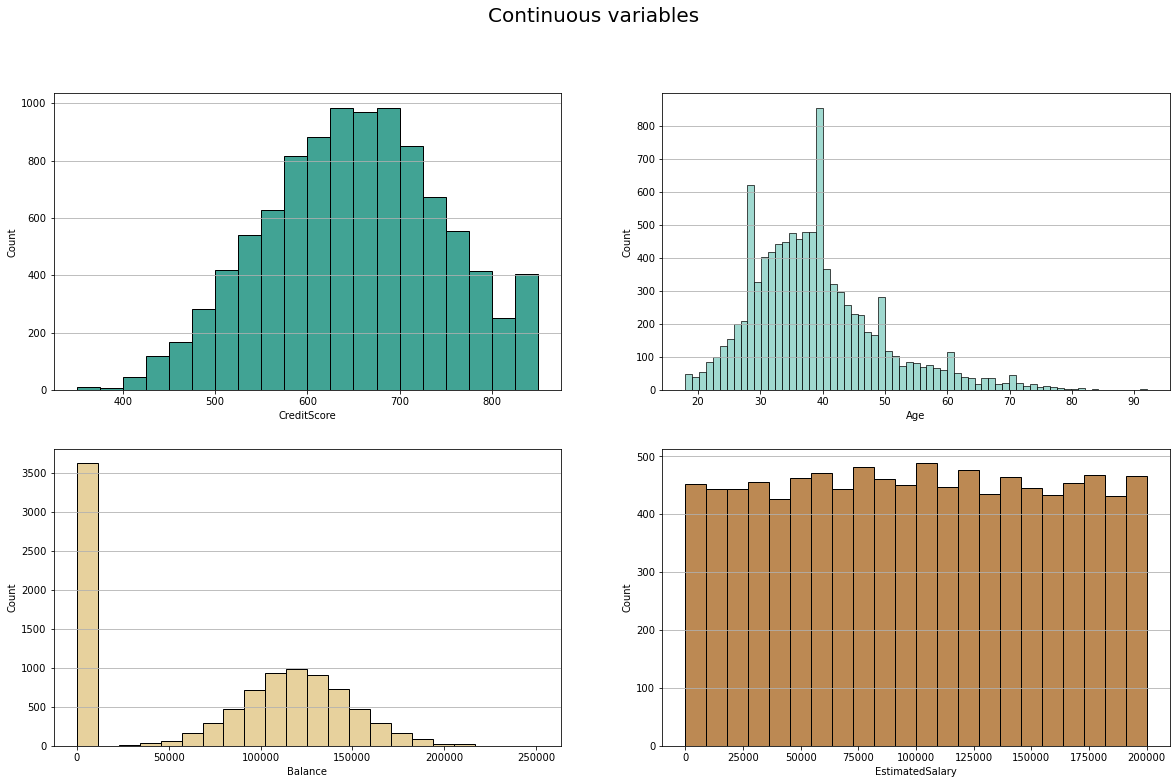

In [10]:
fig, ax = plt.subplots(2,2, figsize=(20,12))

sns.histplot(data=df_bank_churn, x='CreditScore', color='#018571', bins=20, ax=ax[0,0])
ax[0,0].grid(axis='y')

sns.histplot(data=df_bank_churn, x='Age', color='#80cdc1', ax=ax[0,1])
ax[0,1].grid(axis='y')

sns.histplot(data=df_bank_churn, x='Balance', color='#dfc27d', ax=ax[1,0])
ax[1,0].grid(axis='y')

sns.histplot(data=df_bank_churn, x='EstimatedSalary', color='#a6611a', ax=ax[1,1])
ax[1,1].grid(axis='y')

plt.suptitle('Continuous variables', fontsize=20)
plt.show()


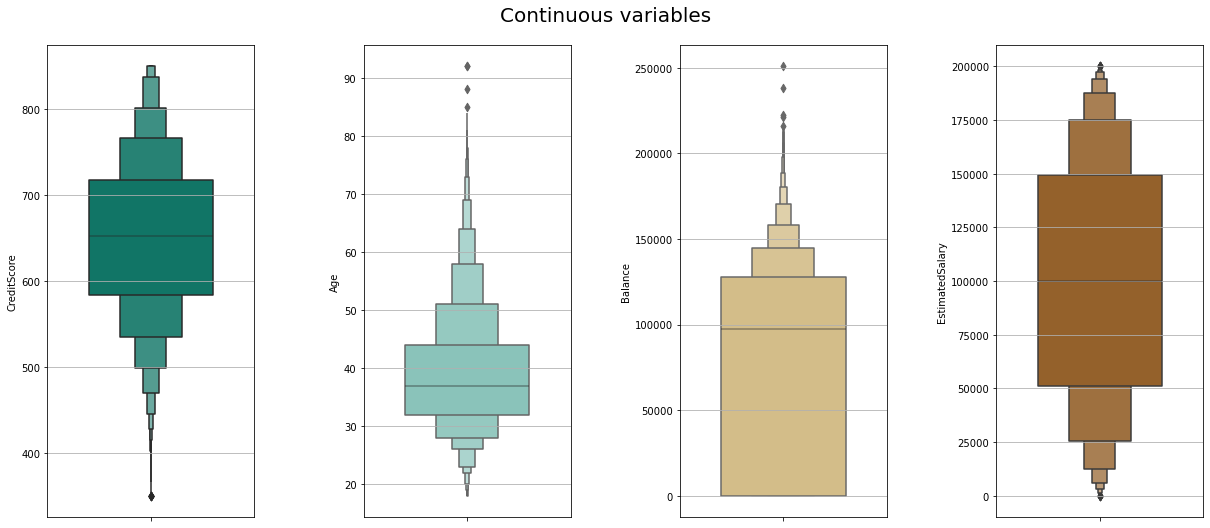

In [11]:
fig, ax = plt.subplots(1,4, figsize=(18,8))

sns.boxenplot(ax=ax[0],y=df_bank_churn['CreditScore'], color='#018571',width=0.6)
ax[0].grid(axis='y')

sns.boxenplot(ax=ax[1],y=df_bank_churn['Age'], color='#80cdc1',width=0.6)
ax[1].grid(axis='y')

sns.boxenplot(ax=ax[2],y=df_bank_churn['Balance'], color='#dfc27d',width=0.6)
ax[2].grid(axis='y')

sns.boxenplot(ax=ax[3],y=df_bank_churn['EstimatedSalary'], color='#a6611a',width=0.6)
ax[3].grid(axis='y')

fig.tight_layout(pad=5.0)
plt.suptitle('Continuous variables', fontsize=20)
plt.show()


**Highlights**
- The average score is between 600 and 700
- Most clients are older than 25 and younger than 50 years old. 
- We seem to have a normal distributions of balance, apart from around 3500 clients who have a zero balance.
- Estimated salary seems to have a uniform distribution, meaning our clients are equally divided aroud all estimated salaries.

### Target Variable

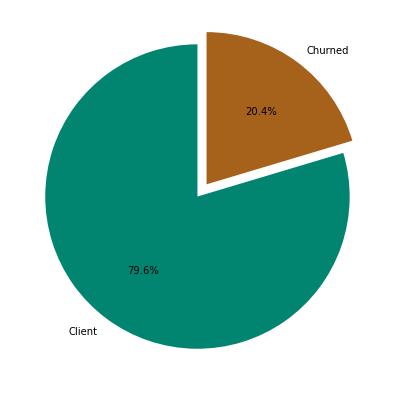

In [12]:
plt.figure(figsize = (7, 7))
plt.pie(x=df_bank_churn.Exited.value_counts(), autopct='%1.1f%%', colors=['#018571','#a6611a'], labels=['Client', 'Churned'], explode=(0, 0.1), startangle=90)
plt.show()

**Highlights**
- In this dataset, 20.4% of clients have left the bank

Next, we will try to figure out what variables are more correlated to the target.

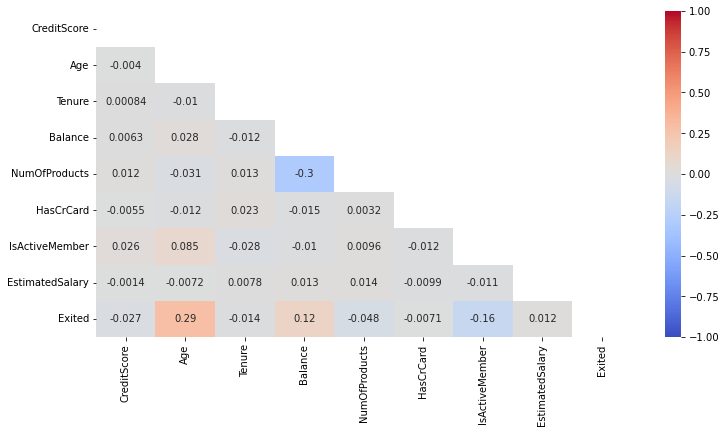

In [13]:
plt.figure(figsize=(12, 6))
mask=np.triu(np.ones_like(df_bank_churn.corr()))
sns.heatmap(df_bank_churn.corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1, mask=mask);

**Highlights**
- 'Age' is the variable that shows most correlation with 'Exited'.
<br/><br/>
Let's explore more about correlations!

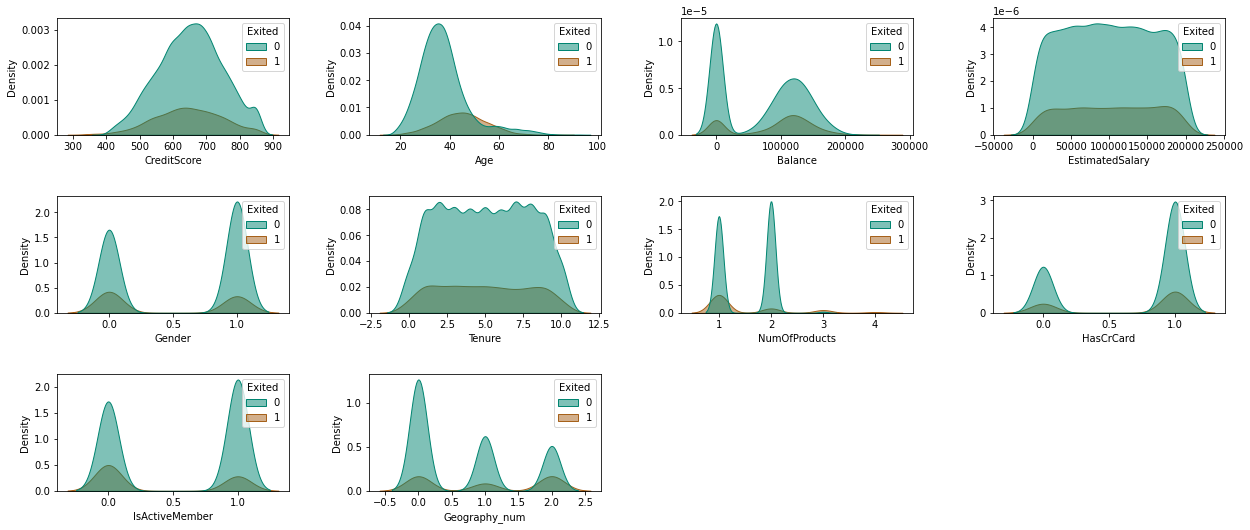

In [14]:
fig, ax = plt.subplots(3,4, figsize=(18,8))


sns.kdeplot(data=df_bank_churn, x='CreditScore',hue="Exited", palette=['#018571','#a6611a'], alpha=.5, linewidth=1, fill=True, ax=ax[0,0])
sns.kdeplot(data=df_bank_churn, x='Age',hue="Exited", palette=['#018571','#a6611a'], alpha=.5, linewidth=1, fill=True, ax=ax[0,1])
sns.kdeplot(data=df_bank_churn, x='Balance',hue="Exited", palette=['#018571','#a6611a'], alpha=.5, linewidth=1, fill=True, ax=ax[0,2])
sns.kdeplot(data=df_bank_churn, x='EstimatedSalary',hue="Exited", palette=['#018571','#a6611a'], alpha=.5, linewidth=1, fill=True, ax=ax[0,3])

#transformando Gender em 0,1 para plotar o gráfico
df_bank_churn.Gender = df_bank_churn.Gender.apply(lambda x: 1 if x == 'Male' else 0)
sns.kdeplot(data=df_bank_churn, x='Gender',hue="Exited", palette=['#018571','#a6611a'], alpha=.5, linewidth=1, fill=True, ax=ax[1,0])

sns.kdeplot(data=df_bank_churn, x='Tenure',hue="Exited", palette=['#018571','#a6611a'], alpha=.5, linewidth=1, fill=True, ax=ax[1,1])

sns.kdeplot(data=df_bank_churn, x='NumOfProducts',hue="Exited", palette=['#018571','#a6611a'], alpha=.5, linewidth=1, fill=True, ax=ax[1,2])

sns.kdeplot(data=df_bank_churn, x='HasCrCard',hue="Exited", palette=['#018571','#a6611a'], alpha=.5, linewidth=1, fill=True, ax=ax[1,3])

sns.kdeplot(data=df_bank_churn, x='IsActiveMember',hue="Exited", palette=['#018571','#a6611a'], alpha=.5, linewidth=1, fill=True, ax=ax[2,0])

df_bank_churn['Geography_num'] = df_bank_churn.Geography.map({'France':0, 'Spain':1, 'Germany':2})
sns.kdeplot(data=df_bank_churn, x='Geography_num',hue="Exited", palette=['#018571','#a6611a'], alpha=.5, linewidth=1, fill=True, ax=ax[2,1])

fig.delaxes(ax[2,2])
fig.delaxes(ax[2,3])

fig.tight_layout(pad=3.0)
plt.show()

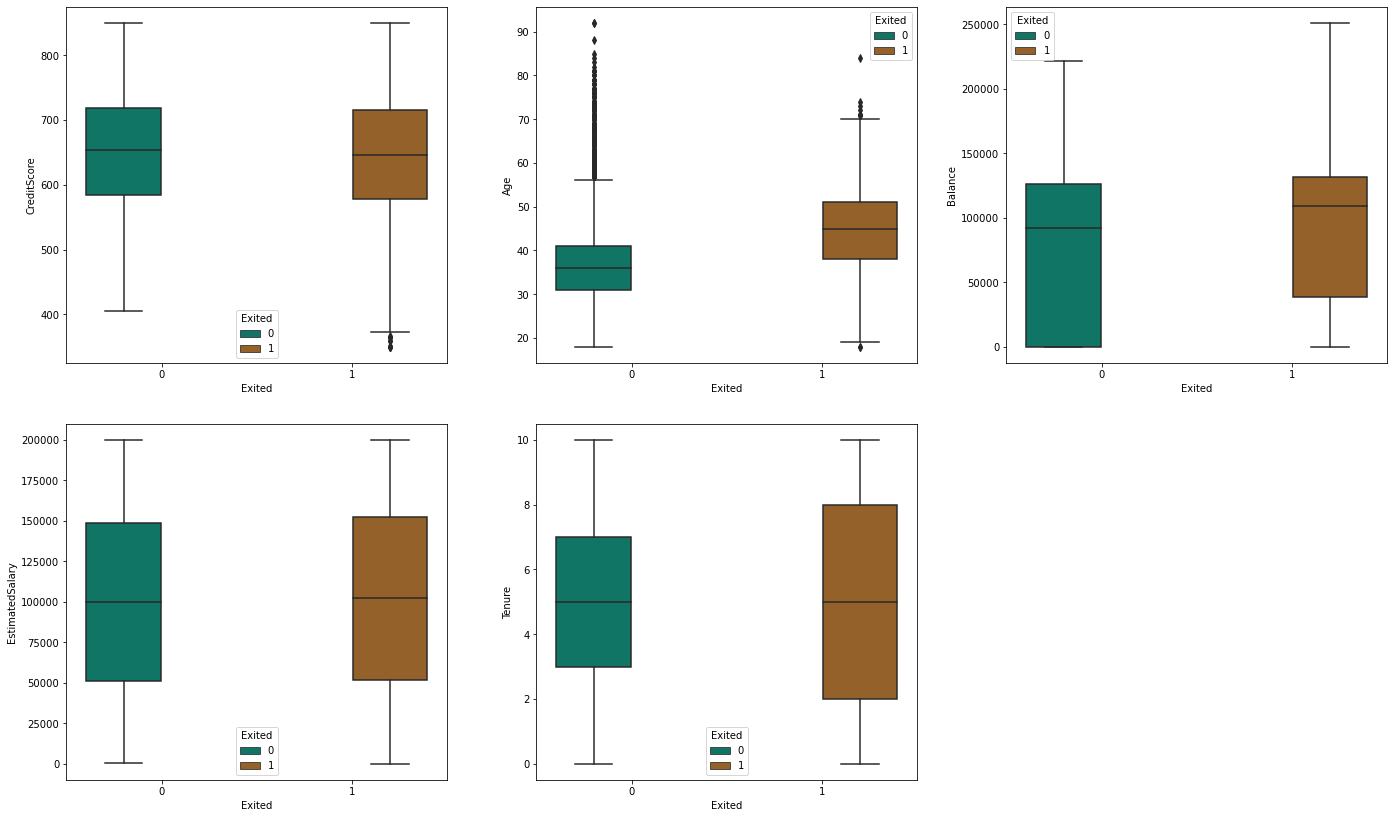

In [15]:
fig, ax = plt.subplots(2,3, figsize=(20,12))


sns.boxplot(data=df_bank_churn, y='CreditScore', x='Exited',hue="Exited", palette=['#018571','#a6611a'], ax=ax[0,0])
sns.boxplot(data=df_bank_churn, y='Age', x='Exited',hue="Exited", palette=['#018571','#a6611a'], ax=ax[0,1])
sns.boxplot(data=df_bank_churn, y='Balance', x='Exited',hue="Exited", palette=['#018571','#a6611a'], ax=ax[0,2])
sns.boxplot(data=df_bank_churn, y='EstimatedSalary', x='Exited',hue="Exited", palette=['#018571','#a6611a'], ax=ax[1,0])
sns.boxplot(data=df_bank_churn, y='Tenure', x='Exited',hue="Exited", palette=['#018571','#a6611a'], ax=ax[1,1])


fig.delaxes(ax[1,2])

fig.tight_layout(pad=3.0)
plt.show()

In [16]:
print('Clients churning based on NumOfProducts')

print('1 product')
print(df_bank_churn[df_bank_churn.NumOfProducts==1].Exited.value_counts(normalize=True).sort_index())

print('2 product')
print(df_bank_churn[df_bank_churn.NumOfProducts==2].Exited.value_counts(normalize=True).sort_index())

print('3 product')
print(df_bank_churn[df_bank_churn.NumOfProducts==3].Exited.value_counts(normalize=True).sort_index())

print('4 product')
print(df_bank_churn[df_bank_churn.NumOfProducts==4].Exited.value_counts(normalize=True).sort_index())

Clients churning based on NumOfProducts
1 product
0    0.722856
1    0.277144
Name: Exited, dtype: float64
2 product
0    0.924183
1    0.075817
Name: Exited, dtype: float64
3 product
0    0.172932
1    0.827068
Name: Exited, dtype: float64
4 product
1    1.0
Name: Exited, dtype: float64


**Highlights**
- CreditScore and EstimatedSalary do not seem to impact churn rate;
- Customers who Churn seem to be **older** than the customers retained; 
- Interestingly enough, customers with 0 balance are not the ones who churn the most;
- We have more Male clients, but **Female tend to churn more**;
- Comparetevely, we would say people from **France churn less**;
- **Not active clients** tend to churn more;
- For NumOfProducts, clients with **2 products** churn less, and almost all clients with 3 or 4 products churn.

**Based on this**, we could say the variables that impact churn the most are:
- **Age**: the bank most focus on their older clients;
- **Geography**: the bank must focus on German and Spanish clients;
- **Gender**: the bank must focus on female clients who tend to churn more;
- **isActiveMember**: the bank must focus on not active clients and try to convert them;
- **NumOfProducts**: the bank must figure out why clients with 3 or 4 products churn so much.

In [17]:
# deleting the 'Geography_num' column
df_bank_churn.drop('Geography_num', axis=1, inplace=True)

# Feature engineering

Before going on, let's see if we can create some features!

In [18]:
# First, lets try to find the ratio between the balance and the estimated salary
df_bank_churn['BalanceSalaryRatio'] = df_bank_churn.Balance/df_bank_churn.EstimatedSalary

#Let's also see the ratio between the Tenure and the Age of the client
df_bank_churn['TenureAgeRatio'] = df_bank_churn.Tenure/df_bank_churn.Age

# We will also calculate ratio between CreditScore and Age
df_bank_churn['ScoreAgeRatio'] = df_bank_churn.CreditScore/df_bank_churn.Age

# Lastly, let's calculate the ratio between Tenure and NumOfProducts
df_bank_churn['TenureProductsRatio'] = df_bank_churn.Tenure / df_bank_churn.NumOfProducts

Let's see the distribution of the new data!

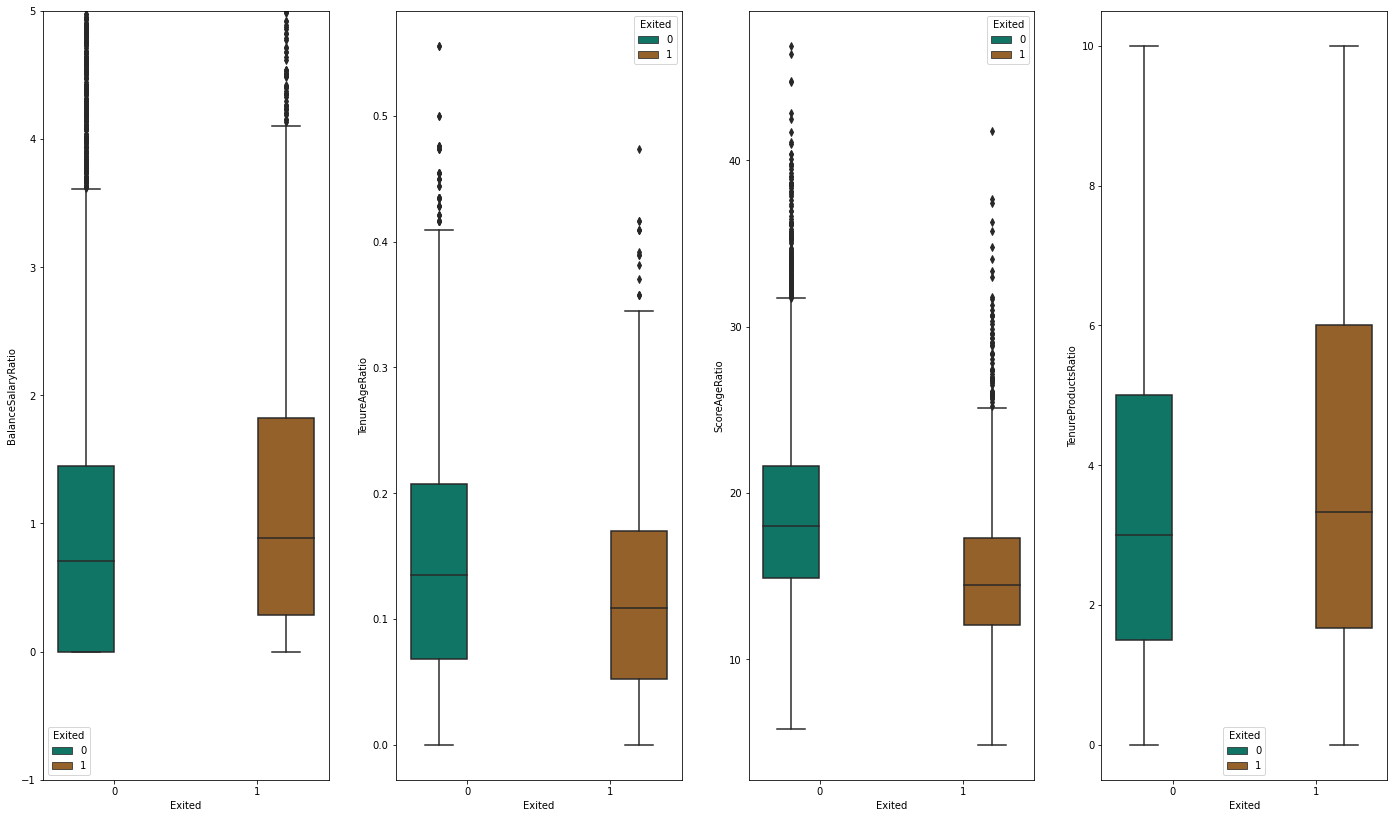

In [19]:
fig, ax = plt.subplots(1,4, figsize=(20,12))


sns.boxplot(data=df_bank_churn, y='BalanceSalaryRatio', x='Exited',hue="Exited", palette=['#018571','#a6611a'], ax=ax[0])
ax[0].set_ylim([-1,5])

sns.boxplot(data=df_bank_churn, y='TenureAgeRatio', x='Exited',hue="Exited", palette=['#018571','#a6611a'], ax=ax[1])

sns.boxplot(data=df_bank_churn, y='ScoreAgeRatio', x='Exited',hue="Exited", palette=['#018571','#a6611a'], ax=ax[2])

sns.boxplot(data=df_bank_churn, y='TenureProductsRatio', x='Exited',hue="Exited", palette=['#018571','#a6611a'], ax=ax[3])


fig.tight_layout(pad=3.0)
plt.show()

As seen in the boxplots above, the ratios calculated above might be useful for diferentiating customers who churn and who stay as clients.
<br/>
Now let's construct our pipelines for variables preparation and also build our models!

# Data Preparation

In [20]:
df_bank_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureAgeRatio,ScoreAgeRatio,TenureProductsRatio
0,619,France,0,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,14.738095,2.000000
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390,14.829268,1.000000
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.190476,11.952381,2.666667
3,699,France,0,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025641,17.923077,0.500000
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,19.767442,2.000000


Let's separate our variables types:

In [21]:
continuous_variables = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'BalanceSalaryRatio', 'TenureAgeRatio', 'ScoreAgeRatio', 'TenureProductsRatio']
discrete_variables = ['Tenure', 'NumOfProducts']
categorical_variables = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

target = 'Exited'

Next, we divide our data into training and test datasets:

In [22]:
df_train, df_test = train_test_split(df_bank_churn, train_size=0.8, random_state=42, stratify=df_bank_churn[target])

X_train = df_train.drop(columns=[target])
X_test = df_test.drop(columns=[target])

y_train = df_train[target]
y_test = df_test[target]

Finally, we set up our pipelines. The numerical data will be [standardized](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler), and the categorical data will be [one-hot-encoded](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), dropping the first category:

In [23]:
pipe_feat_num = Pipeline([
    ('pre_scaling_std', StandardScaler())
])

pipe_categorical = Pipeline([
    ('pre_one_hot', OneHotEncoder(drop='first'))
])

feat_num = continuous_variables + discrete_variables

pipe_pre_processor = ColumnTransformer([
    ('tran_num', pipe_feat_num, feat_num),
    ('tran_cat', pipe_categorical, categorical_variables)
])


# Model Training

We have reached **the** moment!<br/><br/>
For this notebook, we will use and compare the following models: LogisticRegression, RandomForestClassifier and XGBClassifier

**Note**: although the data is not balanced, **we will go on without any treatment** at first. <br/><br/>
LogisticRegression is a model that should take balanced datasets for the best performance and metrics, but tree-based models and XGBClassifier should perform well with the imbalanced dataset [Source](https://rihab-feki.medium.com/imbalanced-data-best-practices-f3b6d0999f38). <br/><br/>Let's see if this happens in practice!

## LogisticRegression

We will create a pipeline to preprocess the data and then train the model.

In [24]:
pipe_lr = Pipeline([
    ('pre_process', pipe_pre_processor),
    ('estimador', LogisticRegression(random_state=42))
])

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('tran_num',
                                                  Pipeline(steps=[('pre_scaling_std',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Balance', 'EstimatedSalary',
                                                   'BalanceSalaryRatio',
                                                   'TenureAgeRatio',
                                                   'ScoreAgeRatio',
                                                   'TenureProductsRatio',
                                                   'Tenure', 'NumOfProducts']),
                                                 ('tran_cat',
                                                  Pipeline(steps=[('pre_one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember'])])),
                ('estimador', LogisticRegression(random_state=42))])

Now we can predict the results, and calulate the ROC_AUC score with predict_proba:

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1593
           1       0.66      0.24      0.35       407

    accuracy                           0.82      2000
   macro avg       0.74      0.60      0.62      2000
weighted avg       0.80      0.82      0.78      2000

ROC_AUC score = 0.7901599596514851


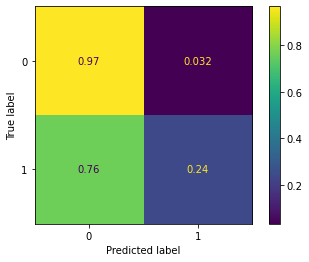

In [25]:
y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:,1])
print(f'ROC_AUC score = {roc}')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

Let's try to improve the roc_auc score using randomized search!

In [26]:
espaco_hiper = {
    'estimador__penalty': ['l1', 'l2'],
    'estimador__C':[0.01, 0.1, 1, 10],
    'estimador__solver':['lbfgs', 'liblinear']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

randomized_lr = RandomizedSearchCV(
    estimator=pipe_lr,
    param_distributions=espaco_hiper,
    scoring='roc_auc',
    cv=cv,
    verbose=3,
    random_state=42
)

randomized_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred))

randomized_lr.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END estimador__C=0.01, estimador__penalty=l1, estimador__solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END estimador__C=0.01, estimador__penalty=l1, estimador__solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END estimador__C=0.01, estimador__penalty=l1, estimador__solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END estimador__C=0.01, estimador__penalty=l1, estimador__solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END estimador__C=0.01, estimador__penalty=l1, estimador__solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END estimador__C=0.01, estimador__penalty=l1, estimador__solver=liblinear;, score=0.750 total time=   0.0s
[CV 2/5] END estimador__C=0.01, estimador__penalty=l1, estimador__solver=liblinear;, score=0.778 total time=   0.0s
[CV 3/5] END estimador__C=0.01, estimador__penalty=l1, estimador__solver=liblinear;, score=0.789 total time=   0.0s
[CV 4/5] END estimador__C=0.01, estimador

{'estimador__solver': 'liblinear',
 'estimador__penalty': 'l2',
 'estimador__C': 1}

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1593
           1       0.66      0.24      0.35       407

    accuracy                           0.82      2000
   macro avg       0.75      0.60      0.62      2000
weighted avg       0.80      0.82      0.78      2000

ROC_AUC score = 0.7901800105189937


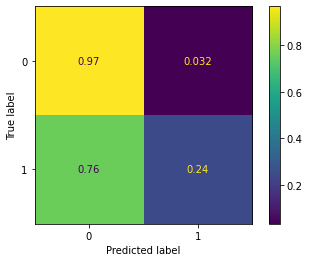

In [27]:
# apparently we can get a better roc by using a different value for C!

pipe_lr_opt = Pipeline([
    ('pre_process', pipe_pre_processor),
    ('estimador', LogisticRegression(solver= 'liblinear', penalty='l2', C= 1, random_state=42))
])

pipe_lr_opt.fit(X_train, y_train)

y_pred = pipe_lr_opt.predict(X_test)
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, pipe_lr_opt.predict_proba(X_test)[:,1])
print(f'ROC_AUC score = {roc}')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

 Overal, we get a **somewhat good ROC with the optimum parameters** found using Random Search, but we still have **too many false negatives**, meaning we predict a lot of costumers won't churn -0 category-, but the reality is they will! <br/><br/>


This may be explained by the fact that LogisticRegression does not work well with imbalanced datasets. Since most of our data is not churning clients, it predicts most of our test dataset won't churn either!

We will go on and see if RandomForestClassifier does a better job...

# RandomForestClassifier

In [28]:
pipe_rfc = Pipeline([
    ('pre_process', pipe_pre_processor),
    ('estimador', RandomForestClassifier(random_state=42))
])

pipe_rfc.fit(X_train, y_train)


Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('tran_num',
                                                  Pipeline(steps=[('pre_scaling_std',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Balance', 'EstimatedSalary',
                                                   'BalanceSalaryRatio',
                                                   'TenureAgeRatio',
                                                   'ScoreAgeRatio',
                                                   'TenureProductsRatio',
                                                   'Tenure', 'NumOfProducts']),
                                                 ('tran_cat',
                                                  Pipeline(steps=[('pre_one_hot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Geography', 'Gender',
                                                   'HasCrCard',
                                                   'IsActiveMember'])])),
                ('estimador', RandomForestClassifier(random_state=42))])

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.80      0.47      0.59       407

    accuracy                           0.87      2000
   macro avg       0.84      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000

ROC_AUC score = 0.8507891558739016


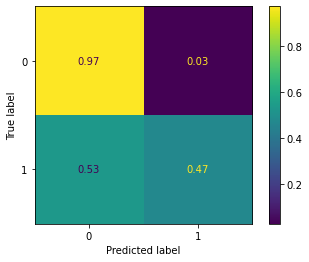

In [29]:
y_pred = pipe_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, pipe_rfc.predict_proba(X_test)[:,1])
print(f'ROC_AUC score = {roc}')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

This model already does a better job than our optimized LogisticRegression, either in ROC or in our false negatives. Let's use RandomizedSearch again and see if we can improve!

In [30]:
espaco_hiper = {
    'estimador__n_estimators': [10,100,200],
    'estimador__criterion':['gini', 'entropy', 'log_loss'],
    'estimador__max_depth':[1, 15, 30],
    'estimador__max_leaf_nodes':[5, 15, 30],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

randomized_rfc = RandomizedSearchCV(
    estimator=pipe_rfc,
    param_distributions=espaco_hiper,
    scoring='roc_auc',
    cv=cv,
    verbose=3,
    random_state=42
)

randomized_rfc.fit(X_train, y_train)

y_pred = randomized_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

randomized_rfc.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END estimador__criterion=entropy, estimador__max_depth=1, estimador__max_leaf_nodes=15, estimador__n_estimators=10;, score=0.784 total time=   0.0s
[CV 2/5] END estimador__criterion=entropy, estimador__max_depth=1, estimador__max_leaf_nodes=15, estimador__n_estimators=10;, score=0.784 total time=   0.0s
[CV 3/5] END estimador__criterion=entropy, estimador__max_depth=1, estimador__max_leaf_nodes=15, estimador__n_estimators=10;, score=0.804 total time=   0.0s
[CV 4/5] END estimador__criterion=entropy, estimador__max_depth=1, estimador__max_leaf_nodes=15, estimador__n_estimators=10;, score=0.755 total time=   0.0s
[CV 5/5] END estimador__criterion=entropy, estimador__max_depth=1, estimador__max_leaf_nodes=15, estimador__n_estimators=10;, score=0.774 total time=   0.0s
[CV 1/5] END estimador__criterion=gini, estimador__max_depth=1, estimador__max_leaf_nodes=5, estimador__n_estimators=10;, score=0.772 total time=   0.0s
[

{'estimador__n_estimators': 100,
 'estimador__max_leaf_nodes': 30,
 'estimador__max_depth': 15,
 'estimador__criterion': 'log_loss'}

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1593
           1       0.87      0.36      0.51       407

    accuracy                           0.86      2000
   macro avg       0.86      0.67      0.71      2000
weighted avg       0.86      0.86      0.83      2000

ROC_AUC score = 0.8526477170544968


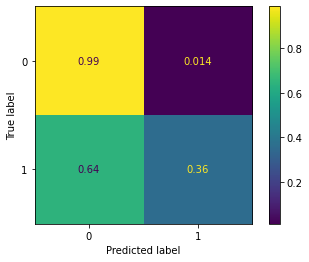

In [31]:
# apparently we can get a better roc by using the value above!

pipe_rfc_opt = Pipeline([
    ('pre_process', pipe_pre_processor),
    ('estimador', RandomForestClassifier(n_estimators= 100, max_leaf_nodes=30, max_depth= 15, criterion= 'log_loss', random_state=42))
])

pipe_rfc_opt.fit(X_train, y_train)

y_pred = pipe_rfc_opt.predict(X_test)
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, pipe_rfc_opt.predict_proba(X_test)[:,1])
print(f'ROC_AUC score = {roc}')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

After the random search algorithm, the new parameters slightly **boosted the ROC score around 0.02 points**, and it also improved the **true negatives** score (+2%), but the **false negatives** score got worse (-11%) than our baseline Random Forest model. 

Is it better than our baseline model? We could only decide for sure with the help of the business analysts.<br/>
But is this the best we can do?. **Let's see if XGBoost can do a better job...**

## XGBClassifier

In [32]:
pipe_xgb = Pipeline([
    ('pre_process', pipe_pre_processor),
    ('estimador', XGBClassifier(random_state=42))
])

pipe_xgb.fit(X_train, y_train)


Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('tran_num',
                                                  Pipeline(steps=[('pre_scaling_std',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Balance', 'EstimatedSalary',
                                                   'BalanceSalaryRatio',
                                                   'TenureAgeRatio',
                                                   'ScoreAgeRatio',
                                                   'TenureProductsRatio',
                                                   'Tenure', 'NumOfProducts']),
                                                 ('tran_cat',
                                                  Pipeline(steps=[('pre_one_hot',
                                                                   OneHotEncoder(drop='first...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))])

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1593
           1       0.71      0.47      0.57       407

    accuracy                           0.85      2000
   macro avg       0.79      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000

ROC_AUC score = 0.8308447122006444


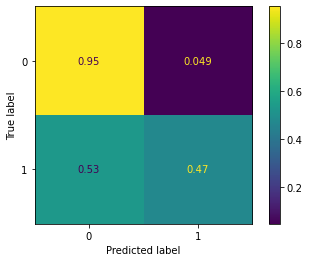

In [33]:
y_pred = pipe_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, pipe_xgb.predict_proba(X_test)[:,1])
print(f'ROC_AUC score = {roc}')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

Let's try to improve on it with Random Search!

In [34]:
espaco_hiper = {
    'estimador__learning_rate': [0.01, 0.1, 0.15, 0.2],
    'estimador__alpha': [0.01, 0.3, 0.8, 1],
    'estimador__colsample_bytree': [0.1, 0.4, 0.8, 1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

randomized_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=espaco_hiper,
    scoring='roc_auc',
    cv=cv,
    verbose=3,
    random_state=42
)

randomized_xgb.fit(X_train, y_train)

y_pred = randomized_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

randomized_xgb.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END estimador__alpha=1, estimador__colsample_bytree=0.4, estimador__learning_rate=0.01;, score=0.860 total time=   0.5s
[CV 2/5] END estimador__alpha=1, estimador__colsample_bytree=0.4, estimador__learning_rate=0.01;, score=0.860 total time=   0.5s
[CV 3/5] END estimador__alpha=1, estimador__colsample_bytree=0.4, estimador__learning_rate=0.01;, score=0.869 total time=   0.5s
[CV 4/5] END estimador__alpha=1, estimador__colsample_bytree=0.4, estimador__learning_rate=0.01;, score=0.834 total time=   0.4s
[CV 5/5] END estimador__alpha=1, estimador__colsample_bytree=0.4, estimador__learning_rate=0.01;, score=0.846 total time=   0.4s
[CV 1/5] END estimador__alpha=1, estimador__colsample_bytree=0.8, estimador__learning_rate=0.15;, score=0.857 total time=   0.7s
[CV 2/5] END estimador__alpha=1, estimador__colsample_bytree=0.8, estimador__learning_rate=0.15;, score=0.865 total time=   0.7s
[CV 3/5] END estimador__alpha=1, est

{'estimador__learning_rate': 0.1,
 'estimador__colsample_bytree': 0.4,
 'estimador__alpha': 0.01}

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.78      0.48      0.59       407

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000

ROC_AUC score = 0.8582619599568753


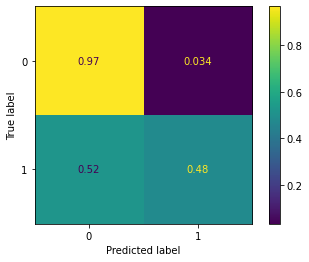

In [35]:
pipe_xgb_opt = Pipeline([
    ('pre_process', pipe_pre_processor),
    ('estimador', XGBClassifier(learning_rate= 0.1, colsample_bytree=0.4, alpha=0.01, random_state=42))
])

pipe_xgb_opt.fit(X_train, y_train)

y_pred = pipe_xgb_opt.predict(X_test)
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, pipe_xgb_opt.predict_proba(X_test)[:,1])
print(f'ROC_AUC score = {roc}')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

This model is surely better than the baseline XGB Model, and it has **the highest ROC so far**!<br/>
As far as **false negatives**, it has the lowest percentage so far, although we still have more than half of the customers who churn being wrongly classified.

Is it good? 
Yes, we can work to save about half the customers who churn.


But is it the best we can do?<br/>
I am not so sure. So I will try to train XGBClassifier again, but balancing balancing the classes!

## XGBoost + oversampling

To balance the classes, I will use the [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) class in the **imblearn libray**.

This is a method where we match the number of occurences of clients who churn and who do not in our dataset. This is done by replicating occurences of the minority class.
<br/><br/>
The image below shows how, in the RandomOverSampler, the existing objects are just replicated. [-SOURCE-](http://glemaitre.github.io/imbalanced-learn/auto_examples/over-sampling/plot_random_over_sampling.html) 

<img src="http://glemaitre.github.io/imbalanced-learn/_images/sphx_glr_plot_random_over_sampling_001.png" width=600>

In [36]:
from imblearn.over_sampling import RandomOverSampler

X = df_bank_churn.drop(columns=['Exited'])
y = df_bank_churn['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

pipe_feat_num = Pipeline([
    ('pre_scaling_std', StandardScaler())
])

pipe_categorical = Pipeline([
    ('pre_one_hot', OneHotEncoder(drop='first'))
])

feat_num = continuous_variables + discrete_variables

pipe_pre_processor = ColumnTransformer([
    ('tran_num', pipe_feat_num, feat_num),
    ('tran_cat', pipe_categorical, categorical_variables)
])


              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1593
           1       0.59      0.63      0.61       407

    accuracy                           0.84      2000
   macro avg       0.75      0.76      0.75      2000
weighted avg       0.84      0.84      0.84      2000

ROC_AUC score = 0.8412526548119769


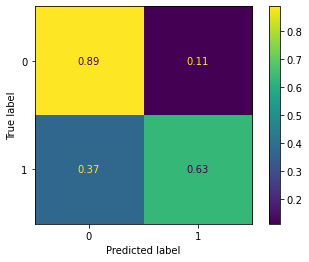

In [37]:
pipe_xgb_ovr = Pipeline([
    ('pre_process', pipe_pre_processor),
    ('estimador', XGBClassifier(random_state=42))
])

pipe_xgb_ovr.fit(X_train, y_train)

y_pred = pipe_xgb_ovr.predict(X_test)
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, pipe_xgb_ovr.predict_proba(X_test)[:,1])
print(f'ROC_AUC score = {roc}')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

With the oversampling, we got a good increase in the recall for customers who churn!

In [38]:
espaco_hiper = {
    'estimador__learning_rate': [0.01, 0.1, 0.15, 0.2],
    'estimador__alpha': [0.01, 0.3, 0.8, 1],
    'estimador__colsample_bytree': [0.1, 0.4, 0.8, 1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

randomized_xgb_ovr = RandomizedSearchCV(
    estimator=pipe_xgb_ovr,
    param_distributions=espaco_hiper,
    scoring='roc_auc',
    cv=cv,
    verbose=3,
    random_state=42
)

randomized_xgb_ovr.fit(X_train, y_train)

y_pred = randomized_xgb_ovr.predict(X_test)
print(classification_report(y_test, y_pred))

randomized_xgb_ovr.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END estimador__alpha=1, estimador__colsample_bytree=0.4, estimador__learning_rate=0.01;, score=0.879 total time=   0.6s
[CV 2/5] END estimador__alpha=1, estimador__colsample_bytree=0.4, estimador__learning_rate=0.01;, score=0.892 total time=   0.6s
[CV 3/5] END estimador__alpha=1, estimador__colsample_bytree=0.4, estimador__learning_rate=0.01;, score=0.897 total time=   0.6s
[CV 4/5] END estimador__alpha=1, estimador__colsample_bytree=0.4, estimador__learning_rate=0.01;, score=0.886 total time=   0.5s
[CV 5/5] END estimador__alpha=1, estimador__colsample_bytree=0.4, estimador__learning_rate=0.01;, score=0.897 total time=   0.5s
[CV 1/5] END estimador__alpha=1, estimador__colsample_bytree=0.8, estimador__learning_rate=0.15;, score=0.939 total time=   0.8s
[CV 2/5] END estimador__alpha=1, estimador__colsample_bytree=0.8, estimador__learning_rate=0.15;, score=0.947 total time=   0.7s
[CV 3/5] END estimador__alpha=1, est

{'estimador__learning_rate': 0.15,
 'estimador__colsample_bytree': 0.8,
 'estimador__alpha': 1}

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1593
           1       0.57      0.66      0.61       407

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.84      0.83      0.83      2000

ROC_AUC score = 0.8520199706640383


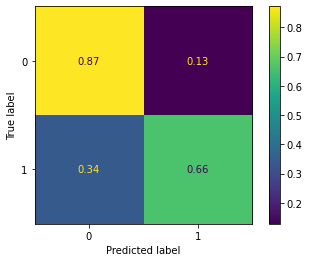

In [39]:
pipe_xgb_ovr_opt = Pipeline([
    ('pre_process', pipe_pre_processor),
    ('estimador', XGBClassifier(learning_rate= 0.15, colsample_bytree=0.8, alpha=1, random_state=42))
])

pipe_xgb_ovr_opt.fit(X_train, y_train)

y_pred = pipe_xgb_ovr_opt.predict(X_test)
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, pipe_xgb_ovr_opt.predict_proba(X_test)[:,1])
print(f'ROC_AUC score = {roc}')

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize='true')).plot()

In terms of ROC/AUC score, we did not get the increase we were expecting with the OverSampling technique.

### **But this shouldn't and isn't the only metric we need to check when choosing a final model.**

Let's plot all of our ROC curves and discuss.

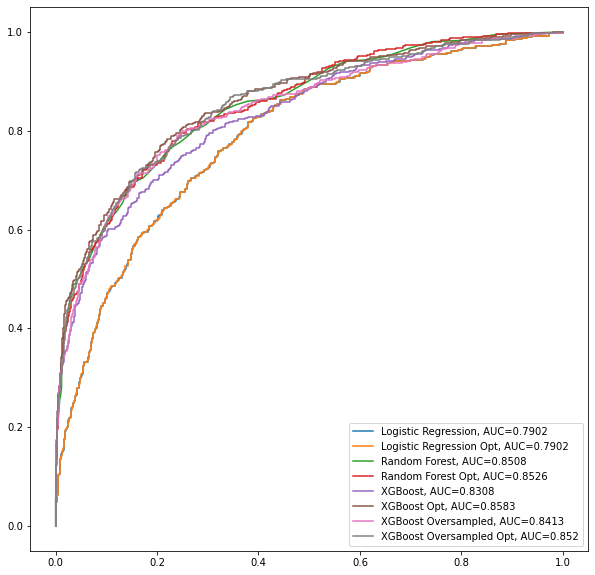

In [40]:
#set up plotting area
plt.figure(0, figsize=(10,10)).clf()

#logistic regression
y_pred = pipe_lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
#logistic regression optmized
y_pred = pipe_lr_opt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression Opt, AUC="+str(auc))

#random forest classifier
y_pred = pipe_rfc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))
#logistic regression optmized
y_pred = pipe_rfc_opt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest Opt, AUC="+str(auc))

#XGBoost
y_pred = pipe_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))
#XGBoost optmized
y_pred = pipe_xgb_opt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost Opt, AUC="+str(auc))

#XGBoost with oversampling
y_pred = pipe_xgb_ovr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost Oversampled, AUC="+str(auc))
#XGBoost with oversampling optmized
y_pred = pipe_xgb_ovr_opt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost Oversampled Opt, AUC="+str(auc))


#add legend
plt.legend()

From the above image, we see that both Random Forest Models, the optmized XGBoost and the optimized XGBoost with Oversampling performed above an 0.85 AUC score. Let's take one example of each to check the classification report and the confusion matrix!!

<img src="images/metric.png" width=900>

Let's first look at the recall metric for category 0 (it is also represented in the yellow square in the confusion matrix). It means **"out of all members who did not churn, how many does my model classify correctly?"**:
- RFC classifies 99% (1577 out of 1593 correctly)
- XGB classifies 97% (1545 out of 1593 correctly)
- RFC classifies 87% (1386 out of 1593 correctly)


Ok, but what really matters is how many customers who churn (category 1) I can find, since these are the ones the bank wants to try to keep. The bottom right square in the Confusion Matrix representes the recall for category one, that is **"out of all members who churned, how many does my model classify correctly?""
- RFC classifies 36% (147 out of 407 correctly)
- XGB classifies 48% (195 out of 1593 correctly)
- XGB + oversampling classifies 66% (268 out of 1593 correctly)

Cool. So in the best scenario, we have the opportunity to avoid 268 clients from churning. But look at the right column in the Confusion matrix. That are all of the clients that the model classified as 1 (clients who will churn):
- RFC classifies 0.014 x 1593 + 0.36 x 407 = 169 clients
- XGB classifies 0.034 x 1593 + 0.48 x 407 = 249 clients
- XGB + oversampling classifies 0.13 x 1593 + 0.66 x 407 = 475 clients

And suppose the bank plans on calling all clients to offer some deal for them not leaving... what is the ratio of maximum clients that could be avoided from churning by clients that it will call:
- RFC: 147/169 = 0.87
- XGB: 195/249 = 0.78
- XGB + oversampling: 268/475= 0.56

So we get to a moment of decision. <br/>
And it all comes down to the bank strategy.

# Recommendation

### Scenario 1

-> Does the bank have time and people to spare and want to avoid the maximum clients from churning? **Then I would suggest the XGB + oversampling model.** The bank, in the best scenario, could have saved 66% of clients who churned!

### Scenario 2

-> Does it have a limited team with limited time and, therefore, it is aware that it will not reach the maximum clients? **Then I would suggest the RFC model.** In the best scenario, it gets to avoid 36% of clients who churned from doing it, with and "efficiency" of 87%. That means, for 100 people called, 87 would be members who would churn.

The XGB model could be used for a scenario in between the above described.